In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.optimize as optimize

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

In [271]:
import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import pycbcwaveform as pycbcwave
import plotparams


import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(pycbcwave)

import constants
imp.reload(constants)
from constants import *

In [224]:
import pycbc.waveform # Waveforms

from constants import *
import waveform as wave


def dimensionless_td_waveform(q, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, lambda1, lambda2, 
                              mf_lower, delta_tbym, approximant='TaylorT4'):
    """Wrapper for pycbc waveforms to make them dimensionless.
    Take dimensionless arguments and return dimensionless waveform.
    """
    # dimensionless -> physical:
    # Pick fiducial mtot = 1Msun and distance = 1Mpc
    # pycbc expects units of Msun and Mpc
    mtot = 1.0
    distance = 1.0
    inclination = 0.0
    
    mass1 = mtot / (1.0 + q)
    mass2 = mtot * q / (1.0 + q)
    
    f_lower = C_SI**3 * mf_lower / (G_SI * MSUN_SI * mtot)
    delta_t = G_SI * MSUN_SI * mtot * delta_tbym / C_SI**3
    
    hp, hc = pycbc.waveform.get_td_waveform(approximant=approximant, 
                        mass1=mass1, mass2=mass2,
                        spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                        spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                        lambda1=lambda1, lambda2=lambda2,
                        distance=distance, inclination=inclination,
                        amplitude_order=0, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower)
    
    hphys = wave.Waveform.from_hp_hc(np.array(hp.sample_times), np.array(hp), np.array(hc))
    hphys.add_x(-hphys.x[0])
    hphys.add_phase(remove_start_phase=True)
    
    # physical -> dimensionless:
    return wave.physical_to_dimensionless_time(hphys, mtot, distance)

In [225]:
#print pycbc.waveform.get_td_waveform.__doc__

In [226]:
q = 0.2
spin1x = -0.2
spin1y = 0.35
spin1z = -0.6
spin2x = 0.22
spin2y = -0.35
spin2z = -0.17
lambda1 = 1000.0
lambda2 = 1000.0

mf_lower = 0.001
delta_tbym = 10.0

h = dimensionless_td_waveform(q, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, lambda1, lambda2, 
                              mf_lower, delta_tbym, approximant='SpinTaylorT1')

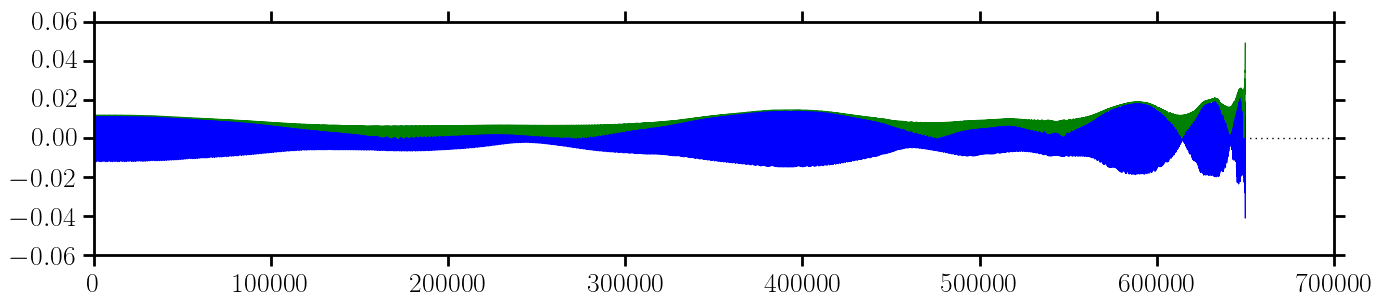

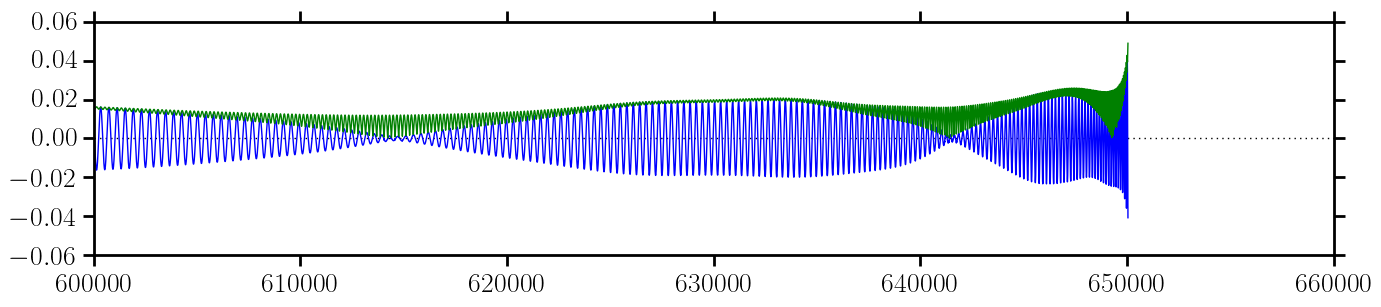

In [227]:
fig, axes = plt.subplots(1, figsize=(16, 3))
wave.plot_waveforms(axes, [h], npoints=10000)
#axes.set_ylim(-0.10, 0.10)

fig, axes = plt.subplots(1, figsize=(16, 3))
wave.plot_waveforms(axes, [h], xi=h.x[-1]-50000, npoints=10000)
#axes.set_ylim(-0.1, 0.1)

In [144]:
################
# Turn off higher order modes in the SpinTaylorTy waveforms and see if the small amplitude oscillations go away.
# Is this done by changing the amplitudeorder argument?
################

q = 0.6
spin1x = -0.3
spin1y = 0.35
spin1z = 0.29
spin2x = 0.22
spin2y = -0.35
spin2z = -0.17
lambda1 = 1000.0
lambda2 = 1000.0

# 2.0e8M long (~10Hz starting):
#mf_lower = 0.0001
mf_lower = 0.001
delta_tbym = 10.0

s1zs = np.linspace(-0.4, 0.4, 101)

params_vs = np.array([[q, spin1x, spin1y, s1z, spin2x, spin2y, spin2z, lambda1, lambda2] for s1z in s1zs])

t1waves = [dimensionless_td_waveform(q, spin1x, spin1y, s1z, spin2x, spin2y, spin2z, lambda1, lambda2, 
                              mf_lower, delta_tbym, approximant='SpinTaylorT1') for s1z in s1zs]

t4waves = [dimensionless_td_waveform(q, spin1x, spin1y, s1z, spin2x, spin2y, spin2z, lambda1, lambda2, 
                              mf_lower, delta_tbym, approximant='SpinTaylorT4') for s1z in s1zs]

(-0.1, 0.1)

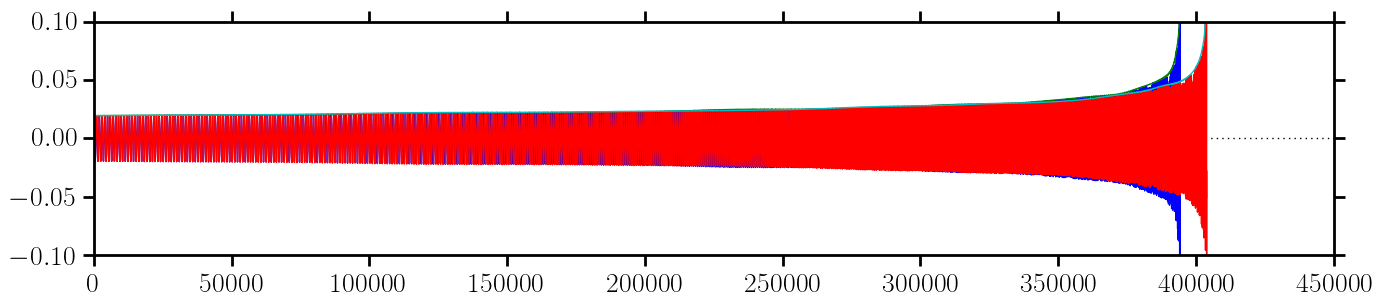

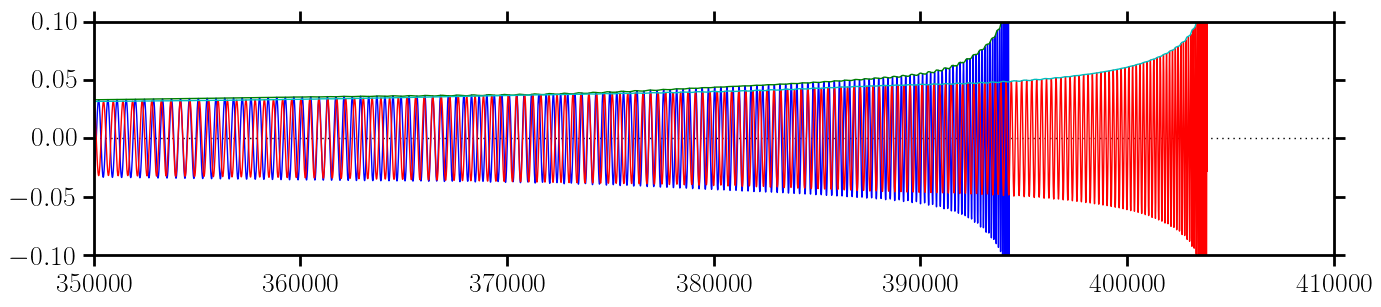

In [145]:
fig, axes = plt.subplots(1, figsize=(16, 3))
wave.plot_waveforms(axes, [t4waves[0], t4waves[-1]], npoints=10000)
axes.set_ylim(-0.10, 0.10)

fig, axes = plt.subplots(1, figsize=(16, 3))
wave.plot_waveforms(axes, [t4waves[0], t4waves[-1]], xi=350000, npoints=10000)
axes.set_ylim(-0.1, 0.1)

In [162]:
x = 365000

ampt1_vs = np.array([t1waves[i].interpolate('amp')(x) for i in range(len(t1waves))])
phaset1_vs = np.array([t1waves[i].interpolate('phase')(x) for i in range(len(t1waves))])

ampt4_vs = np.array([t4waves[i].interpolate('amp')(x) for i in range(len(t4waves))])
phaset4_vs = np.array([t4waves[i].interpolate('phase')(x) for i in range(len(t4waves))])

In [163]:
dphase_vs = phaset4_vs - phaset1_vs

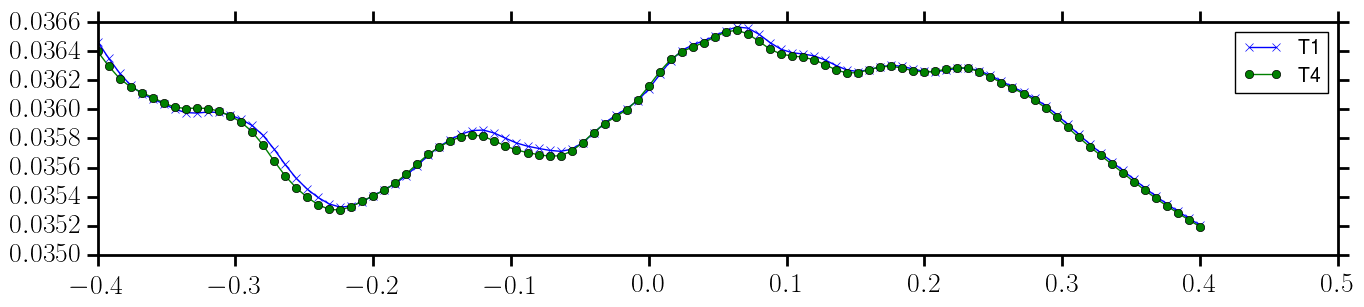

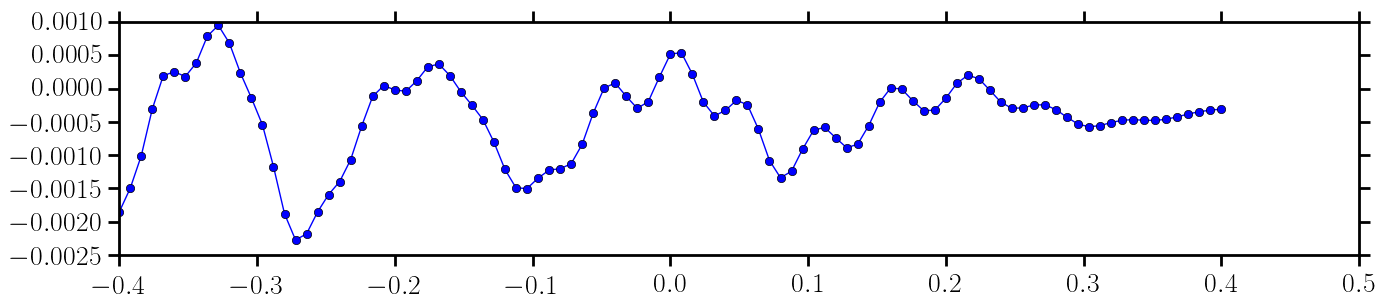

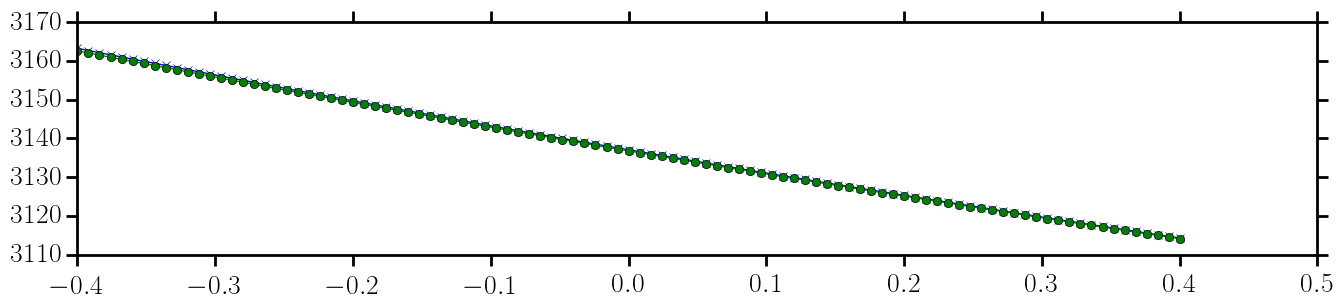

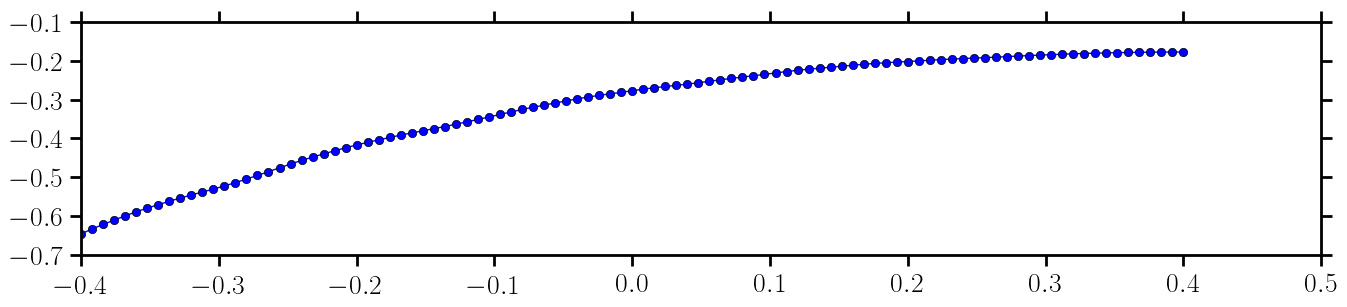

In [164]:
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(s1zs, ampt1_vs, 'x-', label='T1')
axes.plot(s1zs, ampt4_vs, 'o-', label='T4')
axes.legend()

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(s1zs, ampt4_vs/ampt1_vs-1.0, 'o-')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(s1zs, phaset1_vs, 'x-', label='T1')
axes.plot(s1zs, phaset4_vs, 'o-', label='T4')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(s1zs, phaset4_vs-phaset1_vs, 'o-')

# axes.axvline(mf)
# axes.axhline(0.0, c='k')
# axes.axhline(-0.01, c='k')
# axes.axhline(0.01, c='k')
#axes.set_xscale('log')
# axes.set_yscale('log')
# axes.set_ylim(1.0e0, 1.0e3)
#axes.set_yscale('symlog', linthreshy=0.01)
#axes.set_xlabel(r'$Mf$')
#axes.set_ylabel(r'$A/A_{\rm F2}-1$')

512 2.0


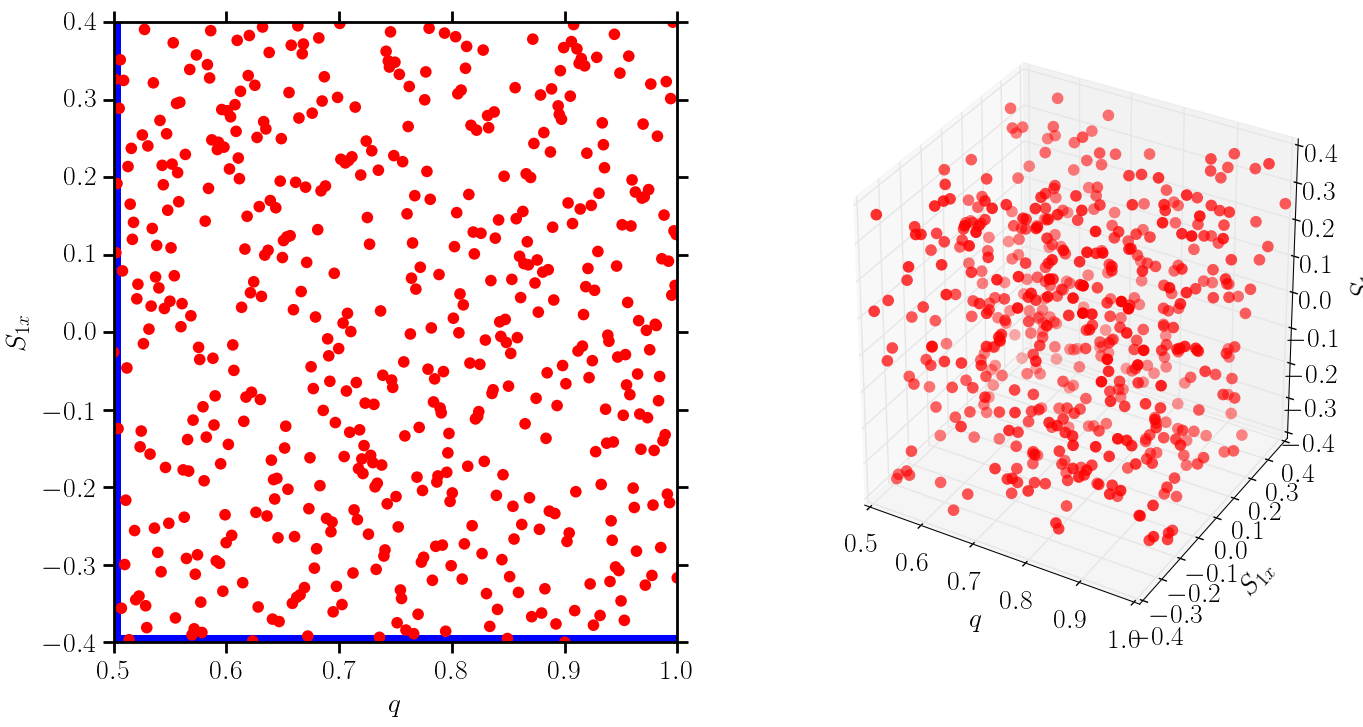

In [229]:
# Make 9d latin hypercube points
Ndata = 2**9
print Ndata, Ndata**(1.0/9.0)
limits = np.array([[0.5, 1.0], 
                   [-0.4, 0.4], [-0.4, 0.4], [-0.4, 0.4], 
                   [-0.4, 0.4], [-0.4, 0.4], [-0.4, 0.4], 
                   [0, 5000], [0, 5000]])
points = gpr.latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(16, 8))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(121)

# for p in points[:, 0]:
#     axes.axvline(p, c='grey', lw=1)

# for p in points[:, 1]:
#     axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$q$')
axes.set_ylabel(r'$S_{1x}$')


# ****** Full 3d data ******
axes = fig.add_subplot(122, projection='3d')

x, y, z = points[:, 0], points[:, 1], points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_zlim(limits[2])
axes.set_xlabel(r'$q$', labelpad=10)
axes.set_ylabel(r'$S_{1x}$', labelpad=15)
axes.set_zlabel(r'$S_{1y}$', labelpad=18)

In [230]:
def make_precessing_td_training_set(filename, points, mf_lower, delta_tbym, approximant):
    """Make a waveform set.
    """
    ts = ws.HDF5WaveformSet(filename)
    
    for i in range(len(points)):
        q, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, lambda1, lambda2 = points[i]
        print i,
        #print q, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, lambda1, lambda2
        h = dimensionless_td_waveform(q, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, lambda1, lambda2, 
                                      mf_lower, delta_tbym, approximant=approximant)
        ts.set_waveform(i, h, points[i])

    return ts

In [231]:
filename = 'precesstdt1.hdf5'
params = points
mf_lower = 0.001
delta_tbym = 10.0
approximant = 'SpinTaylorT1'

trainset_t1 = make_precessing_td_training_set(filename, params, mf_lower, delta_tbym, approximant)
trainset_t1.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [232]:
filename = 'precesstdt4.hdf5'
params = points
mf_lower = 0.001
delta_tbym = 10.0
approximant = 'SpinTaylorT4'

trainset_t4 = make_precessing_td_training_set(filename, params, mf_lower, delta_tbym, approximant)
trainset_t4.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [233]:
trainset_t1 = ws.HDF5WaveformSet('precesstdt1.hdf5')
trainset_t4 = ws.HDF5WaveformSet('precesstdt4.hdf5')
len(trainset_t1), len(trainset_t4)

(512, 512)

In [234]:
# Figure out the magic method that lets you get a waveform with index notation
print np.array([trainset_t1.get_waveform(i).x[-1] for i in range(len(trainset_t1))]).min()
print np.array([trainset_t4.get_waveform(i).x[-1] for i in range(len(trainset_t4))]).min()

369260.0
369730.0


In [235]:
x = 365000

params = trainset_t4.parameters()

ampt1 = np.array([trainset_t1.get_waveform(i).interpolate('amp')(x) for i in range(len(trainset_t1))])
phaset1 = np.array([trainset_t1.get_waveform(i).interpolate('phase')(x) for i in range(len(trainset_t1))])

ampt4 = np.array([trainset_t4.get_waveform(i).interpolate('amp')(x) for i in range(len(trainset_t4))])
phaset4 = np.array([trainset_t4.get_waveform(i).interpolate('phase')(x) for i in range(len(trainset_t4))])

ampdiff = ampt4/ampt1-1.0
dphase = phaset4 - phaset1

In [236]:
for i in range(9):
    print params[:, i].min(), params[:, i].max()

0.5 1.0
-0.4 0.4
-0.4 0.4
-0.4 0.4
-0.4 0.4
-0.4 0.4
-0.4 0.4
0.0 5000.0
0.0 5000.0


In [237]:
dphase.min(), dphase.max()

(-3.1337497432991768, -0.12908608208772421)

In [238]:
phaset4.min(), phaset4.max(), phaset4_vs.min(), phaset4_vs.max()

(3012.2174880425664, 3430.8400853166004, 3114.135609776833, 3162.6032287515904)

In [239]:
dphase.shape, dphase_vs.shape

((512,), (101,))

In [240]:
# Instanciate a Gaussian Process model
kernel_phase = C(2.0, (0.2, 10.0)) * RBF((0.5, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 5000.0, 5000.0), (1.0e-1, 2.0e4)) + WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-2, 1.0))
gp_phase = GaussianProcessRegressor(kernel=kernel_phase, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_phase.fit(params, dphase)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1.41**2 * RBF(length_scale=[0.5, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 5e+03, 5e+03]) + WhiteKernel(noise_level=0.2),
             n_restarts_optimizer=9, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [ ]:
# Instanciate a Gaussian Process model
kernel_amp = C(2.0, (0.2, 10.0)) * RBF((0.5, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 5000.0, 5000.0), (1.0e-1, 2.0e4)) + WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-4, 1.0))
gp_amp = GaussianProcessRegressor(kernel=kernel_amp, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_phase.fit(params, dphase)

In [241]:
gp_phase.predict(np.array([0.5, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, 4000, 4000]).reshape(1, -1), return_std=True)

(array([-0.54337413]), array([ 0.13962315]))

In [242]:
gp_phase.predict(np.array([0.7, 0.2, 0.2, 0.2, -0.2, 0.2, 0.2, 4000, 4000]).reshape(1, -1), return_std=True)

(array([-0.35314073]), array([ 0.10240162]))

In [243]:
# Now compare with validation set
dphase_gp, dphase_gp_err = gp_phase.predict(params_vs, return_std=True)

In [244]:
dphase_gp, dphase_gp_err

(array([-0.65576843, -0.6450372 , -0.63438618, -0.62382033, -0.61334449,
        -0.60296332, -0.59268138, -0.58250306, -0.57243258, -0.56247403,
        -0.55263132, -0.54290821, -0.53330827, -0.52383494, -0.51449145,
        -0.50528087, -0.49620612, -0.48726989, -0.47847475, -0.46982305,
        -0.46131697, -0.45295851, -0.4447495 , -0.43669157, -0.42878618,
        -0.4210346 , -0.41343793, -0.40599707, -0.39871276, -0.39158555,
        -0.38461582, -0.37780377, -0.37114943, -0.36465264, -0.35831311,
        -0.35213033, -0.34610367, -0.34023231, -0.33451529, -0.32895149,
        -0.32353961, -0.31827825, -0.31316583, -0.30820062, -0.3033808 ,
        -0.29870436, -0.29416919, -0.28977306, -0.28551361, -0.28138836,
        -0.27739473, -0.27353002, -0.26979145, -0.26617613, -0.26268107,
        -0.25930321, -0.25603941, -0.25288644, -0.24984101, -0.24689977,
        -0.2440593 , -0.24131615, -0.23866678, -0.23610764, -0.23363514,
        -0.23124564, -0.22893551, -0.22670105, -0.2

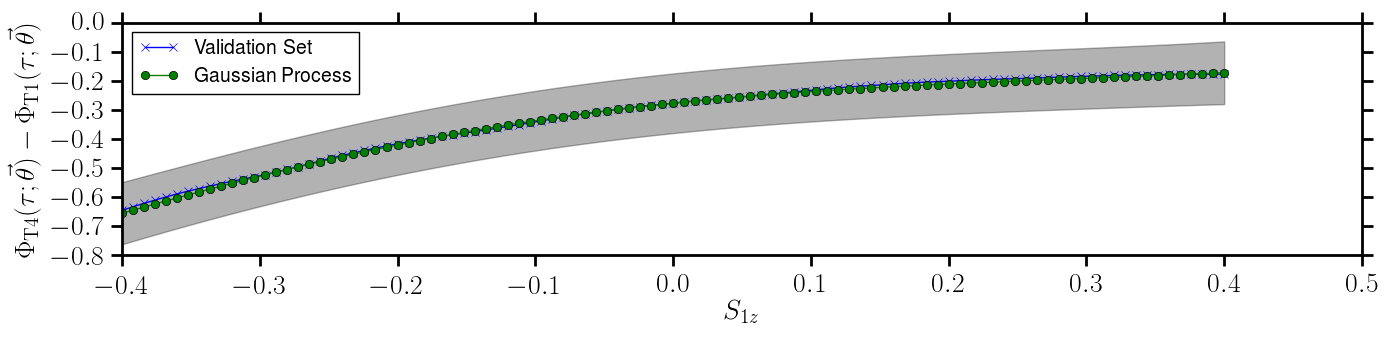

In [245]:
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(params_vs[:, 3], dphase_vs, 'x-', label='Validation Set')
axes.plot(params_vs[:, 3], dphase_gp, 'o-', label='Gaussian Process')
axes.fill_between(params_vs[:, 3], dphase_gp-dphase_gp_err, dphase_gp+dphase_gp_err, color='k', alpha=0.3)
axes.set_ylabel(r'$\Phi_{\rm T4}(\tau; \vec \theta) - \Phi_{\rm T1}(\tau; \vec \theta)$')
axes.set_xlabel(r'$S_{1z}$')
axes.legend(loc='best')

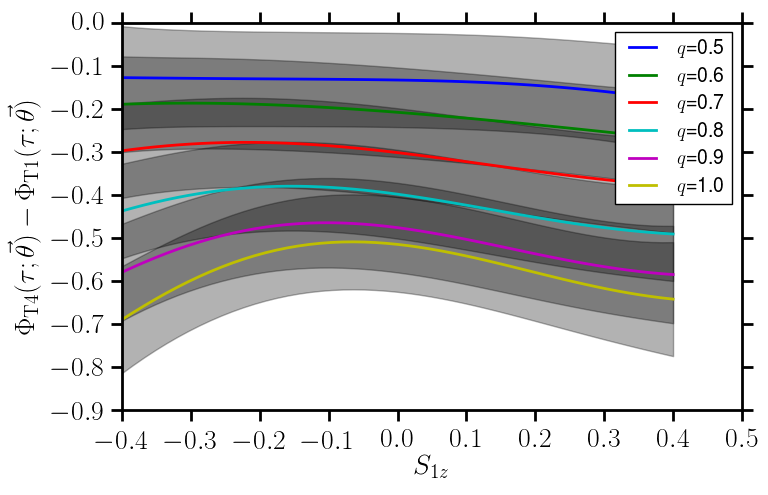

In [246]:
q = 0.7
s1x = 0.3
s1y = 0.3
s1z = 0.3
s2x = 0.3
s2y = -0.3
s2z = -0.2
lambda1 = 1000.0 
lambda2 = 1000.0

fig, ax = plt.subplots(1, figsize=(8, 5))
for q in np.linspace(0.5, 1.0, 6):
    spin = np.linspace(-0.4, 0.4, 51)
    ps = np.array([[q, s1x, s1y, s1z, s2x, s2y, a, lambda1, lambda2] for a in spin])
    
    #true = np.array([func(p) for p in ps])
    #ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    
    y_pred, ysigma = gp_phase.predict(ps, return_std=True)
    #print y_pred
    ax.plot(xs, y_pred, ls='-', lw=2, label=r'$q$='+str(q))
    ax.fill_between(xs, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
#    ax[1].plot(xs, (y_pred-true), label=r'$x_1$='+str(y))
#    ax[1].fill_between(xs, -ysigma, ysigma, color='k', alpha=0.3)

ax.set_ylabel(r'$\Phi_{\rm T4}(\tau; \vec \theta) - \Phi_{\rm T1}(\tau; \vec \theta)$')
ax.legend(loc='best')
#ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax.set_xlabel(r'$S_{1z}$')
#ax[1].set_ylim(-0.1, 0.1)
#ax[0].legend(bbox_to_anchor=(1.25, 1.05))
#ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# Random validation set

In [254]:
# Parameters for the randomly sampled validation set
Ndata = 1000
limits = np.array([[0.5, 1.0], 
                   [-0.4, 0.4], [-0.4, 0.4], [-0.4, 0.4], 
                   [-0.4, 0.4], [-0.4, 0.4], [-0.4, 0.4], 
                   [0, 5000], [0, 5000]])
params = gpr.uniform_random_samples(Ndata, limits)

In [255]:
filename = 'precesstdt1_rand.hdf5'
mf_lower = 0.001
delta_tbym = 10.0
approximant = 'SpinTaylorT1'

randset_t1 = make_precessing_td_training_set(filename, params, mf_lower, delta_tbym, approximant)
randset_t1.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [256]:
filename = 'precesstdt4_rand.hdf5'
mf_lower = 0.001
delta_tbym = 10.0
approximant = 'SpinTaylorT4'

randset_t4 = make_precessing_td_training_set(filename, params, mf_lower, delta_tbym, approximant)
randset_t4.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [276]:
randset_t1 = ws.HDF5WaveformSet('precesstdt1_rand.hdf5')
randset_t4 = ws.HDF5WaveformSet('precesstdt4_rand.hdf5')
len(randset_t1), len(randset_t4)

(1000, 1000)

In [277]:
randset_t1[0]

In [278]:
x = 365000

params_rand = randset_t4.parameters()

ampt1_rand = np.array([randset_t1.get_waveform(i).interpolate('amp')(x) for i in range(len(randset_t1))])
phaset1_rand = np.array([randset_t1.get_waveform(i).interpolate('phase')(x) for i in range(len(randset_t1))])

ampt4_rand = np.array([randset_t4.get_waveform(i).interpolate('amp')(x) for i in range(len(randset_t4))])
phaset4_rand = np.array([randset_t4.get_waveform(i).interpolate('phase')(x) for i in range(len(randset_t4))])

ampdiff_rand = ampt4_rand/ampt1_rand-1.0
dphase_rand = phaset4_rand - phaset1_rand

In [279]:
dphase_rand.max() - dphase_rand.min(), dphase.max() - dphase.min()

(3.5475115679209921, 3.0046636612114526)

In [280]:
# Now compare with validation set
dphase_gp_atrand, dphase_gp_err_atrand = gp_phase.predict(params_rand, return_std=True)

In [281]:
dphase_gp_atrand.shape

(1000,)

In [282]:
phase_err = dphase_gp_atrand - dphase_rand
imax = phase_err.argmax()
params_rand[imax], phase_err[imax]

(array([  9.34245843e-01,   2.97083332e-01,  -7.71500556e-02,
         -3.85154534e-01,  -3.10620745e-01,   1.57981789e-01,
         -3.79005871e-01,   3.93756819e+03,   3.78854649e+03]),
 0.63018266825763636)

In [284]:
params_rand.shape

(1000, 9)

1000


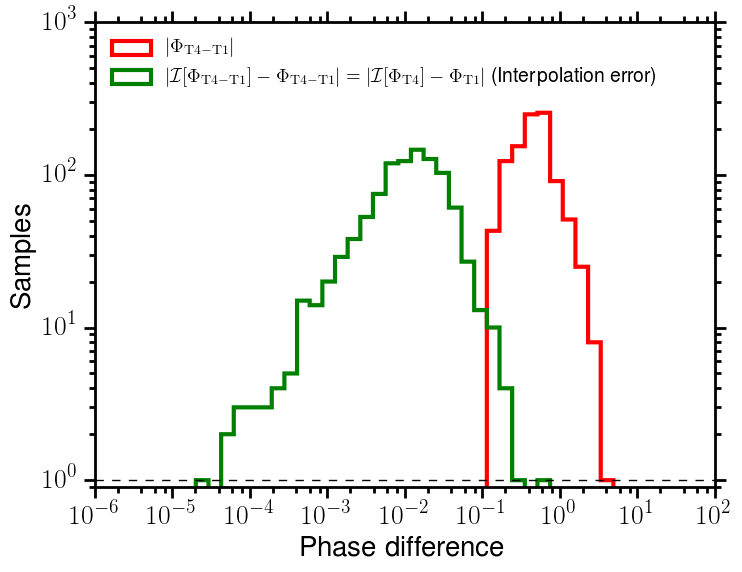

In [347]:
nsamp = len(phase_err)
print nsamp

fig, axes = plt.subplots(1, figsize=(8, 6))

axes.hist(np.abs(dphase_rand), bins=np.logspace(-6, 2, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$|\Phi_{\rm T4-T1}|$')

axes.hist(np.abs(phase_err), bins=np.logspace(-6, 2, 50), histtype='step', 
          ls='-', lw=3, color='green', alpha=1.0, 
          label=r'$|\mathcal{I}[\Phi_{\rm T4-T1}]-\Phi_{\rm T4-T1}| = |\mathcal{I}[\Phi_{\rm T4}]-\Phi_{\rm T1}|$ (Interpolation error)')

axes.axhline(1.0, c='k', ls='--')
axes.set_xscale("log")
axes.set_yscale("log")
#axes.set_xlim([1.0e-4, 100.0])
axes.set_ylim([0.9, 1000])
axes.set_xlabel('Phase difference')
axes.set_ylabel('Samples')
axes.legend(loc='upper left', frameon=False)

In [322]:
def max_error_2d_projection_plot(axes, x, y, error, x_label='x', y_label='y', colorbar=None, colorbarlabel='error'):
    
    # Sort errors so largest errors are plotted on top of smaller errors
    error_params = np.array([error, x, y]).T
    error_params_sort = error_params[error_params[:, 0].argsort()]
    error_max = error_params_sort[-1, 0]
    
    # Scatter plot with colorbar
    sc = axes.scatter(error_params_sort[:, 1], error_params_sort[:, 2], 
                      c=error_params_sort[:, 0], s=100*error_params_sort[:, 0]/error_max,
                      edgecolor='', alpha=1.0)
        
    if colorbar:
        cb = plt.colorbar(mappable=sc, ax=axes)
        cb.set_label(label=colorbarlabel, fontsize=18)
        cb.ax.tick_params(labelsize=14)

    # buffers for plot
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    bufx = 0.05*(xmax - xmin)
    bufy = 0.05*(ymax - ymin)
    
    axes.set_xlim([xmin-bufx, xmax+bufx])
    axes.set_ylim([ymin-bufy, ymax+bufy])
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.minorticks_on()

In [329]:
error = np.abs(phase_err)
p_error = np.concatenate((params_rand.T, np.array([error]))).T

In [345]:
p_error_cutoff = p_error[p_error[:, -1]>0.2]

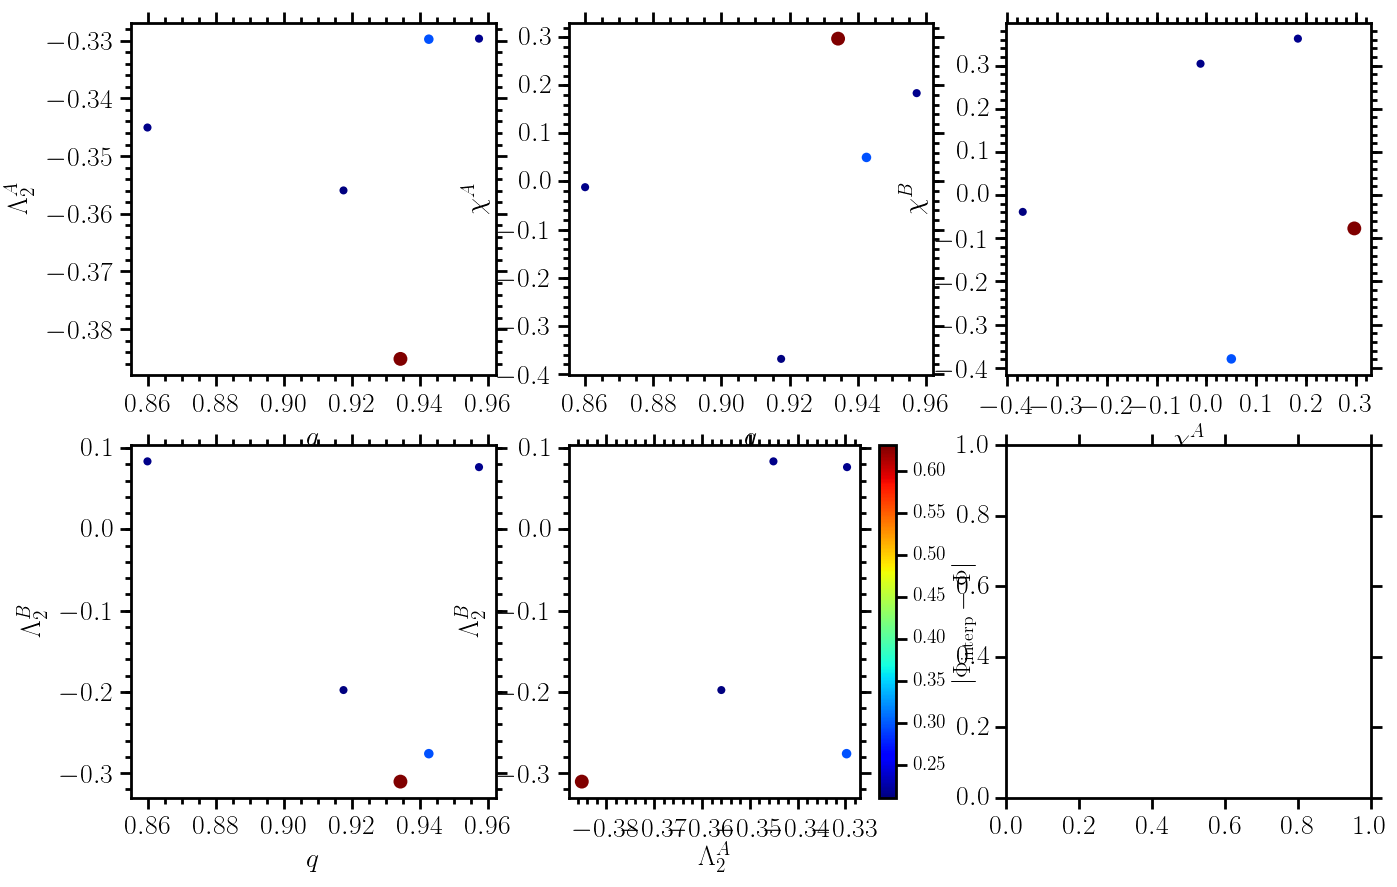

In [346]:
error = p_error_cutoff[:, -1]
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

x = p_error_cutoff[:, 0]
y = p_error_cutoff[:, 3]
max_error_2d_projection_plot(ax[0, 0], x, y, error, x_label=r'$q$', y_label=r'$\Lambda_2^A$', colorbar=None)

x = p_error_cutoff[:, 0]
y = p_error_cutoff[:, 1]
max_error_2d_projection_plot(ax[0, 1], x, y, error, x_label=r'$q$', y_label=r'$\chi^A$', colorbar=None)

x = p_error_cutoff[:, 1]
y = p_error_cutoff[:, 2]
max_error_2d_projection_plot(ax[0, 2], x, y, error, x_label=r'$\chi^A$', y_label=r'$\chi^B$', colorbar=None)

x = p_error_cutoff[:, 0]
y = p_error_cutoff[:, 4]
max_error_2d_projection_plot(ax[1, 0], x, y, error, x_label=r'$q$', y_label=r'$\Lambda_2^B$', colorbar=None)

x = p_error_cutoff[:, 3]
y = p_error_cutoff[:, 4]
max_error_2d_projection_plot(ax[1, 1], x, y, error, x_label=r'$\Lambda_2^A$', y_label=r'$\Lambda_2^B$', colorbar=True, 
                             colorbarlabel=r'$|\Phi_{\rm interp}-\Phi|$')